In [70]:
import os
import numpy as np 
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
PATH = r'.\data\predictive_maintenance.csv'

data = pd.read_csv(
    PATH,
    sep=',',
    header=0,
    index_col=False)
data.drop('UDI', axis=1, inplace=True)
data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [31]:
data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


C:\Users\USER\AppData\Local\Temp/ipykernel_11096/3749458467.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr(method='pearson')


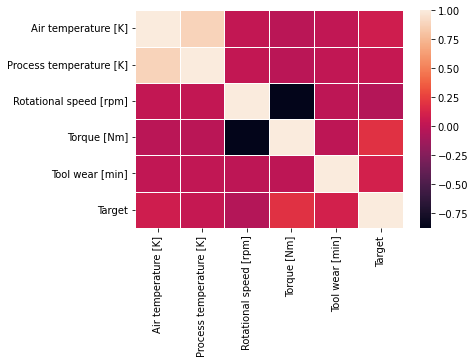

In [32]:
corr = data.corr(method='pearson')

ax = sns.heatmap(corr, linewidth=0.5)

In [74]:
data = data[['Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target']]
data.head(10)

,Rotational speed [rpm],Target
0,1551,0
1,1408,0
2,1498,0
3,1433,0
4,1408,0
5,1425,0
6,1558,0
7,1527,0
8,1667,0
9,1741,0


<Axes: >

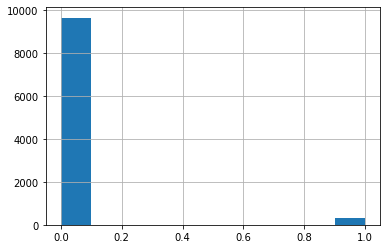

In [34]:
# Que tan sesgados estan los datos
data['Target'].hist()

<Axes: xlabel='Tool wear [min]', ylabel='Count'>

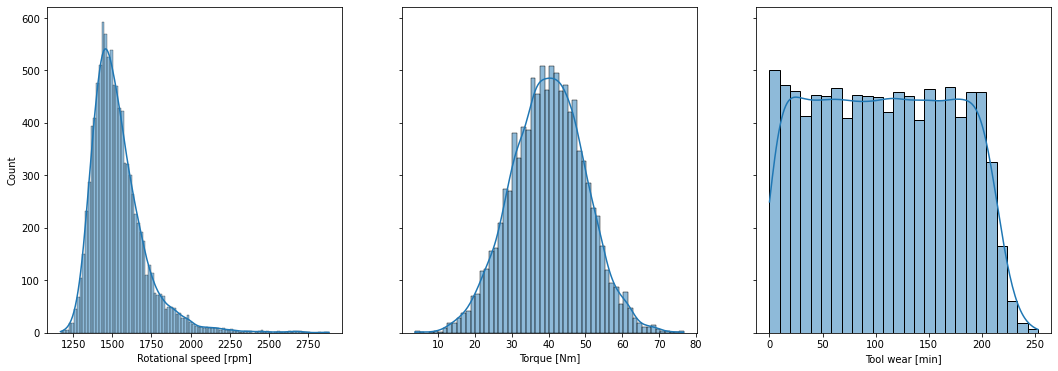

In [35]:
# Revisar que tipo de distribucion tienen las variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x='Rotational speed [rpm]', kde=True)
sns.histplot(data, ax=axes[1], x='Torque [Nm]', kde=True)
sns.histplot(data, ax=axes[2], x='Tool wear [min]', kde=True)

In [39]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y] == i]) / len(df))
    return prior

In [40]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y] == label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((feat_val - mean) ** 2 / (2 * std ** 2)))
    return p_x_given_y

In [41]:
def calculate_liklihood_uniform(df, feat_name, Y, label):
	feat = list(df.columns)
	df = df[df[Y]==label]
	min_val, max_val = df[feat_name].min(), df[feat_name].max()
	p_x_given_y = 1 / (max_val - min_val)
	return p_x_given_y

In [72]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]
    print(features)

    # calculate prior
    prior = calculate_prior(df, Y)
    print(prior)
    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1] * len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                # P(Y | x1) * P(Y | x2) * P(Y | x3)
                if features[i] == 'Tool wear [min]':
                    print('entro aca')
                    likelihood[j] *= calculate_liklihood_uniform(df, features[i], Y, labels[j])
                else: 
                    likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1] * len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [75]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="Target")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

['Rotational speed [rpm]']
[0.965875, 0.034125]
[[1907   27]
 [  57    9]]
0.1764705882352941


In [69]:
np.unique(Y_test, return_counts=True)

(array([0, 1], dtype=int64), array([1934,   66], dtype=int64))

In [ ]:
# Revisar por que se puede remover el denominador en la optimizacion de bayes
rating_probs = data.groupby('Failure Type').size().div(len(data))
type_probs = data.groupby('Type').size().div(len(data))
print(rating_probs)
print(type_probs)
# df.groupby(['Failure Type']).size().div(len(df)).div(rating_probs, axis=0, level='rating')

Failure Type
Heat Dissipation Failure    0.0112
No Failure                  0.9652
Overstrain Failure          0.0078
Power Failure               0.0095
Random Failures             0.0018
Tool Wear Failure           0.0045
dtype: float64
Type
H    0.1003
L    0.6000
M    0.2997
dtype: float64



encontrar funcion de utilidad para tomar la desicion -> hacer o no mantenimiento